# Assignment 3_2: Echo State Networks

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from esn import *
from learning import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000], y_data[:5000] # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:], y_data[5000:]

train_x, val_x = dev_x[:4000], dev_x[4000:]
train_y, val_y = dev_y[:4000], dev_y[4000:]

In [4]:
train_x = train_x.unsqueeze(1).unsqueeze(1) # needed shape by the model
train_x.shape

torch.Size([4000, 1, 1])

In [5]:
val_x = val_x.unsqueeze(1).unsqueeze(1) # needed shape by the model
val_x.shape

torch.Size([1000, 1, 1])

In [6]:
import itertools
import torch
import statistics as st

from esn import *

def grid_search(hyperparameters:dict, train_x, train_y, val_x, val_y, n_iter:int = 5, verbose:bool = False):
    all_config = [dict(zip(hyperparameters.keys(), config)) for config in itertools.product(*hyperparameters.values())]

    model_selection_history = {}
    mse = torch.nn.MSELoss()

    for i, config in enumerate(all_config):
        input_size = train_x.shape[2]

        train_mse = []
        val_mse = []
        washout = config['washout']
        for _ in range(n_iter):
            esn = RegressorESN(input_size=input_size, hidden_size=config['hidden_size'], ridge_regression=config['ridge_regression'],
                            omhega_in=config['omhega_in'], omhega_b=config['omhega_b'], rho=config['rho'], density=1)

            esn.train()        
            h_last = esn.fit(train_x, train_y, washout)
            train_pred = esn(train_x, None)
            train_mse.append(mse(train_pred, train_y).item())
            
            esn.eval()
            val_pred = esn(val_x, h_init=h_last)
            val_mse.append(mse(val_pred, val_y).item())

        model_selection_history[f'config_{i}'] = {**config, 
                                                  'train_mse_mean': st.mean(train_mse), 'train_mse_var': st.variance(train_mse), 
                                                  'val_mse_mean': st.mean(val_mse), 'val_mse_var': st.variance(val_mse)}
        if verbose:
            print(f'Configuration {i}')

    return model_selection_history

In [7]:
hyperparams = {
    'hidden_size': [256, 512, 1024], 
    'ridge_regression':  [1e-6],
    'omhega_in': [0.5],
    'omhega_b': [0.3],
    'rho': [0.7, 0.8, 0.9],
    'washout': [1],
}

model_selection_history = grid_search(hyperparams, train_x, train_y, val_x, val_y, n_iter=5) 

df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('esn_grid_search.csv')

In [8]:
df_results = pd.read_csv('esn_grid_search.csv', index_col=0)
df_results.sort_values(by='val_mse_mean', ascending=True).head(10)

,hidden_size,ridge_regression,omhega_in,omhega_b,rho,washout,train_mse_mean,train_mse_var,val_mse_mean,val_mse_var
config_7,1024,0.000001,0.5,0.3,0.8,1,0.002956,2.234002e-05,0.000001,3.447046e-14
config_8,1024,0.000001,0.5,0.3,0.9,1,0.000420,2.126477e-07,0.000002,1.242004e-13
config_6,1024,0.000001,0.5,0.3,0.7,1,0.014399,1.138376e-04,0.000002,5.254093e-14
config_4,512,0.000001,0.5,0.3,0.8,1,0.002641,8.651338e-06,0.000005,5.315491e-13
config_5,512,0.000001,0.5,0.3,0.9,1,0.003404,1.447184e-05,0.000009,4.912661e-12
config_3,512,0.000001,0.5,0.3,0.7,1,0.139902,1.259382e-02,0.000010,1.019559e-12
config_1,256,0.000001,0.5,0.3,0.8,1,0.055748,7.277948e-03,0.000046,2.686832e-10
config_2,256,0.000001,0.5,0.3,0.9,1,0.010325,1.168917e-04,0.000062,5.035906e-10
config_0,256,0.000001,0.5,0.3,0.7,1,0.594589,9.103768e-01,0.000088,6.938746e-10


In [7]:
esn = RegressorESN(input_size=1, hidden_size=1024, ridge_regression=1e-6, omhega_in=0.5, omhega_b=0.3, rho=0.8)
washout = 1

In [8]:
h = esn.fit(train_x, train_y, washout=washout)

torch.Size([4000, 1024])


In [9]:
esn.train()
res = esn(train_x, None)

In [10]:
l = torch.nn.L1Loss()
l(res[1:11], train_y[1:11])

tensor(5.5963e-05, dtype=torch.float64)

In [11]:
l = torch.nn.L1Loss()
l(res[:1], train_y[:1])

tensor(4.8961, dtype=torch.float64)

In [39]:
res.shape

torch.Size([4000])

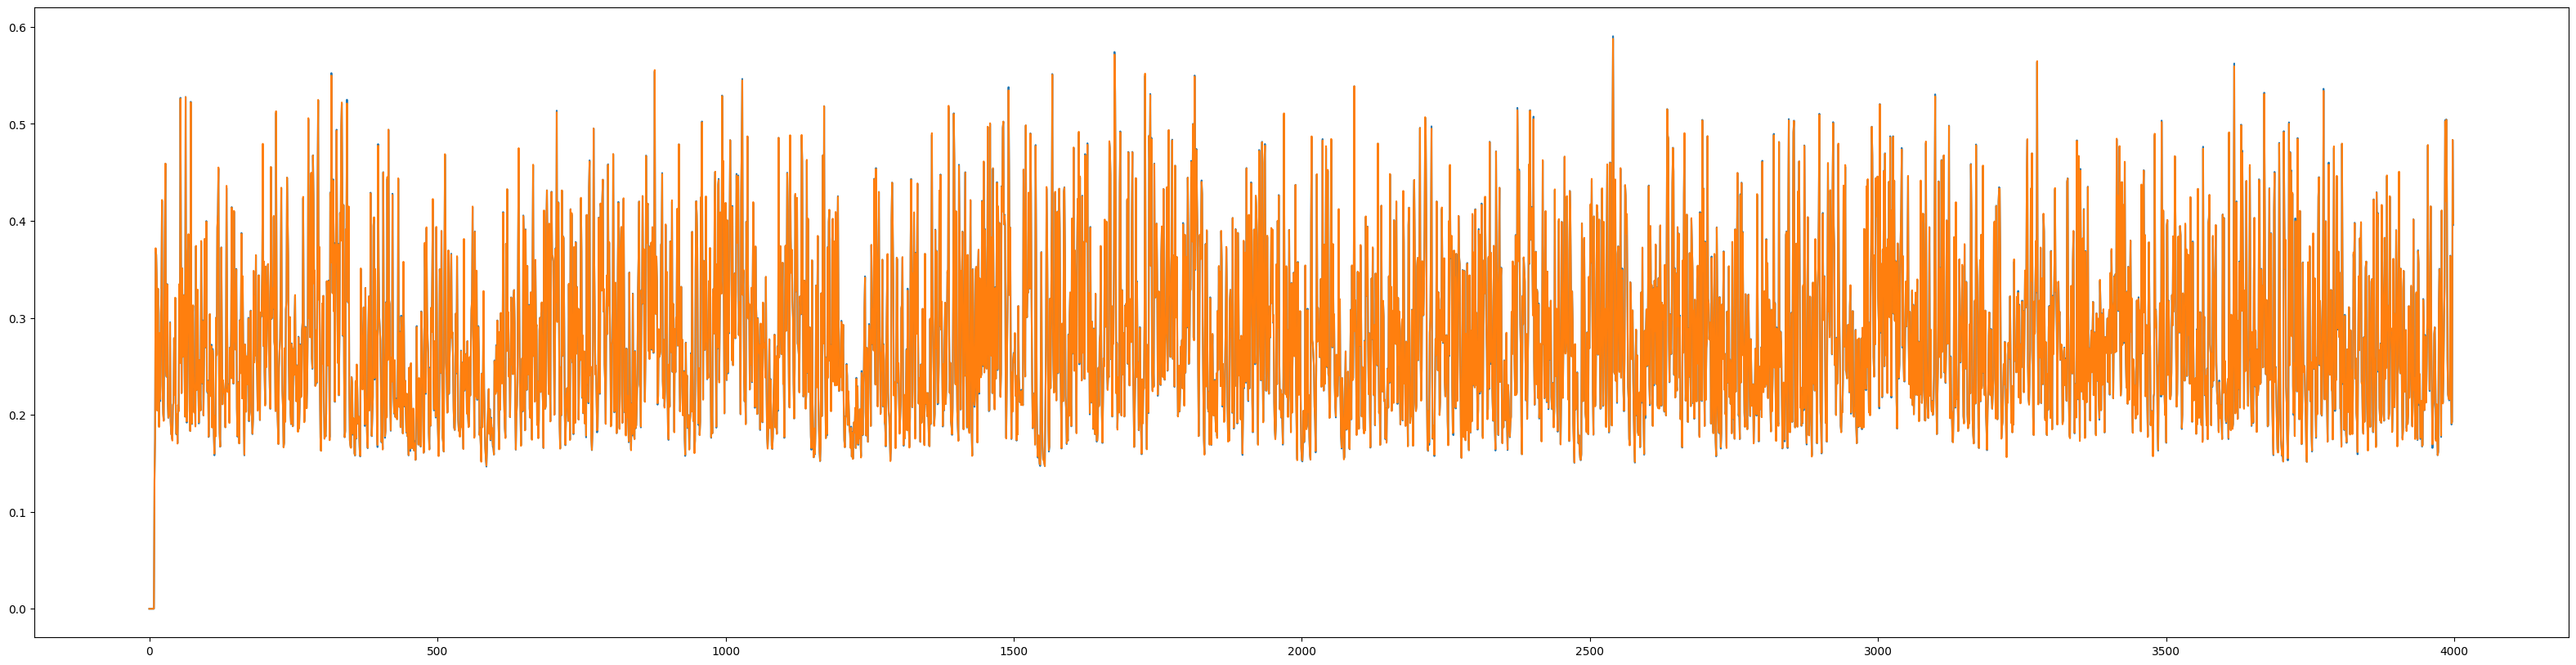

In [14]:
plt.figure(figsize=(40, 10))
plt.plot(train_y[1:])
plt.plot(res[1:])